# Chicago to Croxton
This notebook selects the route from the 47th Street Intermodal yard in Chicago IL to the Croxton Yard in NJ. We will make sure it passes through the desired yard along the route so that we can create the sub routes after the fact. This will improve the elevation filtering needed. Things get a little wonky on the ends. This will better ensure consistency.

In [1]:
import geopandas as gpd
import networkx as nx
from shapely import geometry, ops
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import folium
import time
from requests.auth import AuthBase
import os
from scipy.spatial import distance

In [2]:
URL ="http://score-web-1:8000"
URL1 = URL+"/api-token-auth/"
payload = {'username':'locomotives', 'password':'locomotives'}
URL2 = URL+"/api/line/add/"
URL3 = URL+'/api/railroad/'
URL4 = URL + "/api/line/"
URL5 = URL + "/api/route/add/"
URL6 = URL + "/api/yard/all/"
URL7 = URL + "/api/yard/"
URL8 = URL + "/api/route/detail/"
URL9 = URL + "/api/route/elevations/update/"
URL10 = URL + "/api/yard/add/"

In [3]:
t = requests.post(URL1, data=payload )
token = t.json().get('token')

In [4]:
class TokenAuth(AuthBase):
    """ Implements a custom authentication scheme. """

    def __init__(self, token):
        self.token = token

    def __call__(self, r):
        """ Attach an API token to a custom auth header. """
        r.headers['Authorization'] = "Token " + f'{self.token}'
        return r

Lets do a  quick test to make sure we can commmunicate with the server and grab the list of railroads.

In [5]:
r = requests.get(URL3, auth=TokenAuth(token))
railroads=r.json()['results']
railroads

[{'id': 1, 'code': 'BNSF', 'name': 'Burlington Northern and Santa Fe'},
 {'id': 2, 'code': 'CN', 'name': 'Canadian National Railway'},
 {'id': 3, 'code': 'CP', 'name': 'Canadian Pacific Railway'},
 {'id': 4, 'code': 'CSXT', 'name': 'CSX Transportation'},
 {'id': 5, 'code': 'NS', 'name': 'Norfolk Southern Railway'},
 {'id': 6, 'code': 'KCS', 'name': 'Kansas City Southern Railway'},
 {'id': 7, 'code': 'UP', 'name': 'Union Pacific'}]

When defining a route, we need a starting and and ending location. These typically occur in railraod yards. We can grab the list of available yards from the server.

We want to start this route at the 47th Street yard, but we will select a node or two beyond this to smooth out the ends a bit.

In [7]:
response = requests.get(URL7+'15', auth=TokenAuth(token))
start = response.json()['results']
start

{'id': 15,
 'code': 'C47',
 'name': '47th Street Intermodal',
 'city': 'Chicago',
 'state': 'IL',
 'location': 414683,
 'owner': 5}

and end at the Croxton yard

In [8]:
response = requests.get(URL7+'10', auth=TokenAuth(token))
end = response.json()['results']
end

{'id': 10,
 'code': 'CXT',
 'name': 'Croxton',
 'city': 'Croxton',
 'state': 'NJ',
 'location': 489625,
 'owner': 5}

In [9]:
data = gpd.read_file("North_American_Rail_Network_Lines.geojson")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [10]:
ns_data = data[data[['rrowner1', 'rrowner2', 'rrowner3', 'trkrghts1', 'trkrghts2', 'trkrghts3', 'trkrghts4', 'trkrghts5', 'trkrghts6', 'trkrghts7', 'trkrghts8', 'trkrghts9']].isin(['NS']).any(axis=1)]
#ns_data = data

## Determine the shortest route
We use the networkx library to determine the "optimal" route between two nodes on a graph. For this optimization, the graph consists of all nodes and "edges" or lines for which NOrfolk Southern has owns or has rights. This was determiend above.

In [11]:
from_nodes = list(ns_data.frfranode)

In [12]:
to_nodes = list(ns_data.tofranode)

The nodes in the graph is a union of all of the to and from nodes in the dataset.

In [13]:
all_nodes = list(set(from_nodes) | set(to_nodes))

The next step is to actually create a graph.

In [14]:
G=nx.Graph()

In [15]:
G.add_nodes_from(all_nodes)

We need to add the edges between the nodes and give them a weighting of the distance between the nodes - this will result in the shortest route.

In [16]:
edges = ns_data[['frfranode','tofranode', 'miles']].to_records(index=False).tolist()

In [17]:
G.add_weighted_edges_from(edges)

It would make sense to simply go from the start to the end, but in this case, we are going to add a node or two to the ends to improve the elevation smoothing later.

In [18]:
start_node = 414698 # start['location']
end_node = 489565 # end['location']

In [19]:
route = nx.astar_path(G, start_node, end_node)

In [20]:
route_data = ns_data[(ns_data['frfranode'].isin(route) & ns_data['tofranode'].isin(route))]

In [21]:
fig = folium.Figure(height=600)
map = folium.Map(location=[40.75, -85.0], zoom_start=10,tile=None)
folium.TileLayer(tiles='http://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png', attr='OpenStreetMap attribution').add_to(map)
folium.TileLayer(tiles='http://{s}.google.com/vt/lyrs=s,h&x={x}&y={y}&z={z}', attr='Google Maps').add_to(map)
folium.GeoJson(route_data).add_to(map)
map.add_to(fig)

This route does not take us through Cleveland, so we need to remove a few nodes from the allowable list.

In [22]:
G.remove_node(451258) # this node will push it through Maple Heights
# G.remove_node(452268) # this should make us route through Cleveland - it is in Canton, OH
# G.remove_node(452283) # this is a parallel siding through Canton
G.remove_node(437112) # this node will push it through Fort Wayne rather than Toledo
G.remove_node(477808) # Rutherford 
G.remove_node(477804) # Rutherford
G.remove_node(464648) # Pitcarin yard

In [23]:
route2 = nx.astar_path(G,start_node, end_node)

In [24]:
route2_data = ns_data[(ns_data['frfranode'].isin(route2) & ns_data['tofranode'].isin(route2))]

In [25]:
fig = folium.Figure(height=600)
map = folium.Map(location=[40.75, -85.0], zoom_start=10,tile=None)
folium.TileLayer(tiles='http://{s}.tiles.openrailwaymap.org/standard/{z}/{x}/{y}.png', attr='OpenStreetMap attribution').add_to(map)
folium.TileLayer(tiles='http://{s}.google.com/vt/lyrs=s,h&x={x}&y={y}&z={z}', attr='Google Maps').add_to(map)
folium.GeoJson(route2_data).add_to(map)
map.add_to(fig)

In [26]:
len(route2_data.geometry.get_coordinates())

18381

In [27]:
start['location']

414683

In [28]:
response = requests.get(URL7+'14', auth=TokenAuth(token))
mph = response.json()['results']
mph

{'id': 14,
 'code': 'MPH',
 'name': 'Maple Heights Intermodal',
 'city': 'Cleveland',
 'state': 'OH',
 'location': 450869,
 'owner': 5}

In [29]:
response = requests.get(URL7+'13', auth=TokenAuth(token))
pit = response.json()['results']
pit

{'id': 13,
 'code': 'PTC',
 'name': 'Pitcairn Intermodal',
 'city': 'Pittsburgh',
 'state': 'PA',
 'location': 464679,
 'owner': 5}

In [30]:
response = requests.get(URL7+'12', auth=TokenAuth(token))
rfd = response.json()['results']
rfd

{'id': 12,
 'code': 'RFD',
 'name': 'Rutherford Intermodal',
 'city': 'Harrisburg',
 'state': 'PA',
 'location': 477836,
 'owner': 5}

In [31]:
response = requests.get(URL7+'11', auth=TokenAuth(token))
abm = response.json()['results']
abm

{'id': 11,
 'code': 'ABM',
 'name': 'Bethlehem Intermodal',
 'city': 'Bethlehem',
 'state': 'PA',
 'location': 483750,
 'owner': 5}

Lets test to see if the desired via nodes are in the dataset.

In [47]:
route2_data[route2_data['tofranode'].isin([pit['location']])|route2_data['frfranode'].isin([pit['location']])]

objectid  fraarcid  frfranode  tofranode stfips cntyfips stcntyfips  \
110044    110649    411124     464683     464679     42      003      42003   
121307    122003    422514     464421     464679     42      003      42003   

       stateab country  fradistrct  ...  yardname passngr stracnet tracks net  \
110044      PA      US           2  ...      None       A        S    3.0   M   
121307      PA      US           2  ...  PITCAIRN       A        S    3.0   M   

           miles        km timezone shape_Length  \
110044  0.139375  0.224302        E     0.002092   
121307  3.014907  4.852032        E     0.052698   

                                                 geometry  
110044  MULTILINESTRING ((-79.76751 40.38474, -79.7683...  
121307  MULTILINESTRING ((-79.81241 40.39503, -79.8122...  

[2 rows x 35 columns]

In [54]:
len(route2)

742

This route looks good, we can now move onto the next phase, simplification and segmentation. There are 3219 cooridnataes in this route. This can be reduced with simplify. Before we simplify, we need to convert the coordinate reference system to be in meters.

In [56]:
len(route2_data)

775

There are a number of additional lines added that are parallel to the desired ones. THis can be seen by inspecting the len of route2 and route2_data.

In [32]:
route2_data = route2_data.to_crs(3857)
simple_route = route2_data.simplify(1, preserve_topology=False)

In [33]:
len(simple_route)

775

To better support the estimation of gradient (and may also assist in curvature), we should segmentize the data to have a maximum distance between points.

In [34]:
simple2_route = simple_route.segmentize(max_segment_length=200)
simple2_route = simple2_route.to_crs(4326)
len(simple2_route.geometry.get_coordinates())

13944

In [58]:
len(simple2_route)

775

We get the necessary altitudes at this point. This is a relative long process of querrying. The data in the dataframe consists of a number of line segments. In this case there are 277.

In [35]:
def curve(p1, p2, p3):
    v1=p2-p1
    v2=p3-p2
    v3=p1-p3
    d1=np.linalg.norm(v1)
    d2=np.linalg.norm(v2)
    d3=np.linalg.norm(v3)
    num = 1746.375*2*np.linalg.norm(np.cross(v1,v2))
    d = num/(d1*d2*d3)
    if d<0.01:
        d=0.0
    return d

In [36]:
route2_xy = route2_data.copy()

In [37]:
route2_ll = route2_data.to_crs(4326)

In [62]:
API_KEY=

In [63]:
def get_alt(lat, lng):
    st = ""
    # print(lng)
    for i in range(len(lng)):
        st+=str(lat[i])+','+str(lng[i])+'|'
    st=st[:-1]
    url = "https://maps.googleapis.com/maps/api/elevation/json?locations=" + st + "&key=" + API_KEY
    # print(url)
    response = requests.get(url)
    # result = response.json()['results']['elevation']
    # print(response.status)
    # print(response.json()['results'])
    results = response.json()['results']
    res = []
    for rec in results:
        res.append(rec['elevation'])
    # should put in a test for response status before returning an actual value
    return res

In [64]:
codes = [d['code'] for d in railroads]
codes

['BNSF', 'CN', 'CP', 'CSXT', 'NS', 'KCS', 'UP']

we need to explode the multiliestrings that are being used now to be linestrings

In [65]:
route2_xy.geometry=simple2_route.to_crs(3857)
route2_xy2 = route2_xy.explode(index_parts=True)

In [66]:
np.array(route2_xy2.iloc[0].geometry.coords)

array([[-8352511.07505557,  4961247.58535544],
       [-8352445.08513973,  4961157.99385092],
       [-8352379.09522389,  4961068.4023464 ],
       [-8352271.00399833,  4960917.27619155],
       [-8352162.91277277,  4960766.15003669],
       [-8352054.45048224,  4960608.57436898],
       [-8351945.98819171,  4960450.99870126],
       [-8351837.52590118,  4960293.42303354],
       [-8351730.90274116,  4960140.94652214],
       [-8351624.27958114,  4959988.47001075],
       [-8351517.65642112,  4959835.99349935],
       [-8351411.03326111,  4959683.51698796],
       [-8351304.41010109,  4959531.04047657],
       [-8351197.78694107,  4959378.56396517],
       [-8351091.16378105,  4959226.08745378],
       [-8351017.65952127,  4959134.45835922],
       [-8350944.15515019,  4959053.3020406 ],
       [-8350860.71785225,  4958985.23586997],
       [-8350789.33200239,  4958937.0531495 ]])

Test to add one row

In [67]:
route2_ll.geometry=simple2_route
route2_ll2 = route2_ll.explode(index_parts=True)
np.array(route2_ll2.iloc[0].geometry.coords)

array([[-75.03188359,  40.65268919],
       [-75.0312908 ,  40.6520786 ],
       [-75.030698  ,  40.651468  ],
       [-75.029727  ,  40.65043801],
       [-75.028756  ,  40.649408  ],
       [-75.02778167,  40.64833402],
       [-75.02680733,  40.64726002],
       [-75.025833  ,  40.646186  ],
       [-75.02487519,  40.64514672],
       [-75.02391738,  40.64410743],
       [-75.02295956,  40.64306812],
       [-75.02200175,  40.64202879],
       [-75.02104394,  40.64098945],
       [-75.02008613,  40.63995009],
       [-75.01912831,  40.63891071],
       [-75.01846801,  40.6382861 ],
       [-75.01780771,  40.63773288],
       [-75.01705818,  40.63726889],
       [-75.01641691,  40.63694043]])

In [68]:
def create_row(rowxy, rowll, rights, url, token=None):
    p = np.array(rowxy.geometry.coords)
    pxy = p[:,0:2]
    # we want the interpoint distance between the points - the offset of 1, diagonal of the cdist matrix
    dist = np.diagonal(distance.cdist(pxy, pxy), offset=1)
    lng,lat = rowll.geometry.xy
    ele=get_alt(lat, lng)
    lnglat = np.array(rowll.geometry.coords)
    dele = np.diff(ele)
    gradient = np.divide(dele, dist)
    curvature=[]
    if (len(pxy)>2):
        for i in range(len(pxy)-2):
            curvature.append(curve(pxy[i],pxy[i+1],pxy[i+2]))
        curvature.append(curvature[-1])
    else:
        curvature = [0.0]
    line = {
        "fra_id" : rowxy['fraarcid'],
        "from_node" : rowxy['frfranode'],
        "to_node" : rowxy['tofranode'],
        "length" :dist.sum(),
        "rights" : rights,
        "net": rowxy['net'],
        "xy": pxy.tolist(),
        "elevation": ele,
        "lnglat": lnglat.tolist(),
        "gradient": gradient.tolist(),
        "curvature": curvature,
        "distance":dist.tolist()
    }
    requests.post(url, data=line, auth=TokenAuth(token))
    print(line['fra_id'])
        

In [69]:
create_row(route2_xy2.iloc[0], route2_ll2.iloc[0], [5], URL2, token)

379492


In [70]:
for i in range(len(route2_xy2)):
    # first test to see if it already exists
    fra_id = route2_xy2.iloc[i]['fraarcid']
    response = requests.get(URL4+str(fra_id), auth=TokenAuth(token))
    # if (response.status_code == 204):
    create_row(route2_xy2.iloc[i], route2_ll2.iloc[i], [5], URL2, token)
    # print(route2_xy2.iloc[i][['fraarcid','frfranode', 'tofranode','net','miles']]) 

379492
379495
379496
379984
379988
380143
380144
380160
380250
380262
380274
380296
380312
380322
380324
380356
380390
380401
380402
380403
380414
380415
380418
380451
380466
380562
380563
380606
380615
380622
380624
380628
380645
380657
380761
380762
380925
380927
380942
380999
381000
381009
381010
381137
381139
381670
381763
382011
382133
382134
382141
382172
383433
385250
385251
385382
385949
385950
385951
385955
385956
386000
386001
386802
386804
386832
387310
387311
388360
388361
389417
389874
389875
390312
390313
390346
390351
390423
390424
390449
390459
390526
390607
390630
391032
536626
391092
391093
391171
391177
391178
392179
392915
392916
392937
392938
393128
393134
393168
393188
393191
393683
393696
393787
393819
393848
393869
393904
393907
395029
395032
395042
395043
395064
395065
395069
395110
395121
395122
395123
395129
395133
395173
395177
395208
395219
395220
395221
395222
395223
395224
395225
395226
395234
395248
395253
395292
395301
395303
395304
395371
395384
395385

The next step to saving a route is to include an  ordered list of nodes used make the route.

In [71]:
len(route2_xy2)

775

In [72]:
response = requests.get(URL6, auth=TokenAuth(token))

In [73]:
response

<Response [200]>

In [74]:
response.json()

{'results': [{'id': 2, 'name': 'Rickenbacker'},
  {'id': 4, 'name': 'Norfolk'},
  {'id': 3, 'name': 'Croxton'},
  {'id': 6, 'name': 'Savannah'},
  {'id': 7, 'name': 'Macon'},
  {'id': 8, 'name': 'Tyrone'},
  {'id': 9, 'name': 'State College'},
  {'id': 5, 'name': 'Suffolk'},
  {'id': 10, 'name': 'Croxton'},
  {'id': 1, 'name': 'Landers Yard'},
  {'id': 14, 'name': 'Maple Heights Intermodal'},
  {'id': 15, 'name': '47th Street Intermodal'},
  {'id': 11, 'name': 'Bethlehem Intermodal'},
  {'id': 13, 'name': 'Pitcairn Intermodal'},
  {'id': 12, 'name': 'Rutherford Intermodal'}]}

In [75]:
route = {
    'origin': 15,
    'destination': 10,
    'owner': 5,
    'path': route2
}

In [77]:
res = requests.post(URL5, data=route, auth=TokenAuth(token))

In [78]:
res.json()

{'results': 5}

In [79]:
response = requests.get(URL8+'5', auth=TokenAuth(token))

In [80]:
response.status_code

200

In [81]:
segments=response.json()['results']['segments']

In [82]:
start_elevation = response.json()['results']['start_elevation']

We can push the data into a Pandas dataframe easily.

In [83]:
seg_df = pd.DataFrame(segments)

In [84]:
seg_df

length   degrees  gradient      distance  max_speed   elevation  \
0      150.812946  1.669484  0.001147  1.508129e+02         60  185.138947   
1      125.752893  0.000000 -0.002941  2.765658e+02         60  184.769150   
2      125.752893  0.855419  0.004539  4.023187e+02         60  185.339996   
3      186.977924  0.000000  0.003077  5.892967e+02         60  185.915268   
4      186.977924  0.000000  0.002505  7.762746e+02         60  186.383621   
...           ...       ...       ...           ...        ...         ...   
12534  179.060461  0.000000 -0.000882  1.893998e+06         60    1.900021   
12535  179.060461  0.000000  0.000651  1.894177e+06         60    1.742087   
12536  196.681681  0.000000 -0.000306  1.894374e+06         60    1.858627   
12537  196.681681  0.000000 -0.000029  1.894570e+06         60    1.798506   
12538  120.013334  0.242237  0.000095  1.894690e+06         60    1.792705   

       order  
0          0  
1          1  
2          2  
3          3  
4          4  
...      ...  
12534  12534  
12535  12535  
12536  12536  
12537  12537  
12538  12538  

[12539 rows x 7 columns]

<Axes: xlabel='distance'>

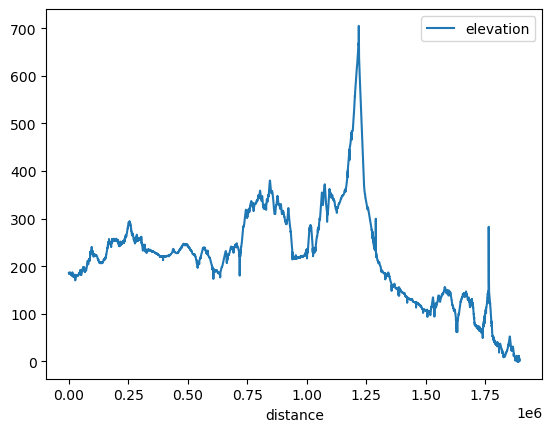

In [85]:
seg_df.plot(x="distance", y="elevation")

<Axes: xlabel='distance'>

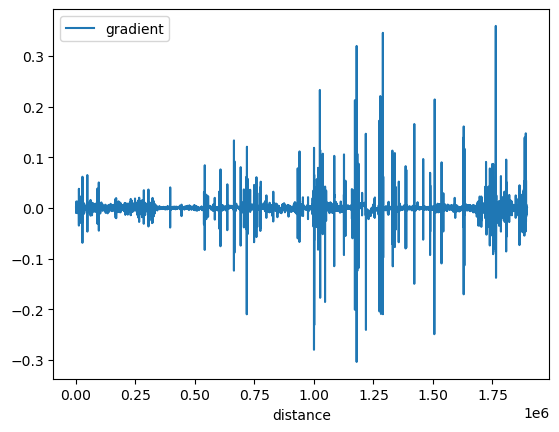

In [86]:
seg_df.plot(x="distance", y="gradient")

In [87]:
def savgol_nonuniform(x, y, window_length, polyorder, deriv=0):
    """
    Savitzky-Golay smoothing 1D filter

    :param x:
    :param y:
    :param window_length: the smoothing sample, e.g. window_length=2 for smoothing over 5 points
    :param polyorder: the degree of the local polynomial fit, e.g. polyorder=2 for a parabolic fit
    :param deriv: The order of the derivative to compute. This must be a nonnegative integer.
            The default is 0, which means to filter the data without differentiating.
    :return:
    """
    if type(x) is not np.array:
        x = np.array(x)
    if type(y) is not np.array:
        y = np.array(y)

    n = int((window_length - 1) / 2)

    if x.shape != y.shape:
        raise RuntimeError("x and y arrays are of different shape")
    if x.shape[0] < window_length:
        raise RuntimeError("not enough data to start the smoothing process")
    if 2 * n + 1 <= polyorder + 1:
        raise RuntimeError("need at least deg+1 points to make the polynomial")

    # smooth start and end data
    ysm = np.zeros(y.shape)
    for i in range(n):
        j = y.shape[0] - i - 1
        if deriv == 0:
            ysm[i] = y[i]
            ysm[j] = y[j]
        if deriv == 1:
            ysm[i] = (y[i] - y[i - 1]) / (x[i] - x[i - 1])
            ysm[j] = (y[j] - y[j - 1]) / (x[j] - x[j - 1])
        if deriv == 2:
            ysm[i] = (((y[i] - y[i - 1]) / (x[i] - x[i - 1])) - ((y[i - 1] - y[i - 2]) / (x[i - 1] - x[i - 2]))) / \
                     (x[i] - x[i - 1])
            ysm[j] = (((y[j] - y[j - 1]) / (x[j] - x[j - 1])) - ((y[j - 1] - y[j - 2]) / (x[j - 1] - x[j - 2]))) / \
                     (x[j] - x[j - 1])
        if deriv >= 3:
            raise NotImplementedError("derivatives >= 3 not implemented")

    m = 2 * n + 1  # the size of the filter window
    o = polyorder + 1  # the smoothing order
    A = np.zeros((m, o))  # A matrix
    t = np.zeros(m)
    # start smoothing
    for i in range(n, x.shape[0] - n):
        for j in range(m):
            t[j] = x[i + j - n] - x[i]
        for j in range(m):
            r = 1.0
            for k in range(o):
                A[j, k] = r
                r *= t[j]
        tA = A.transpose()  # A transposed
        tAA = np.matmul(tA, A)  # make tA.A
        tAA = np.linalg.inv(tAA)  # make (tA.A)-¹ in place
        tAAtA = np.matmul(tAA, tA)  # make (tA.A)-¹.tA

        # compute the polynomial's value at the center of the sample
        ysm[i] = 0.0
        for j in range(m):
            ysm[i] += tAAtA[deriv, j] * y[i + j - n]

    return ysm

In [88]:
x=np.insert(np.array(seg_df['distance']),0,0.0,axis=0)

In [89]:
y=np.insert(np.array(seg_df['elevation']),0, start_elevation, axis=0)

In [120]:
new_elevations = savgol_nonuniform(x,y, 27, 3, 0)
seg_df['new_elevations']=new_elevations[1:]

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

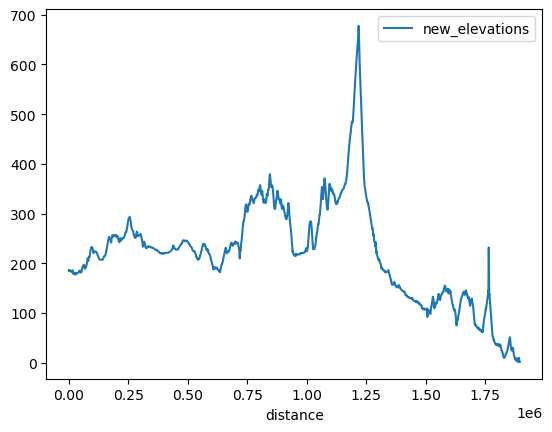

In [121]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["new_elevations"])

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

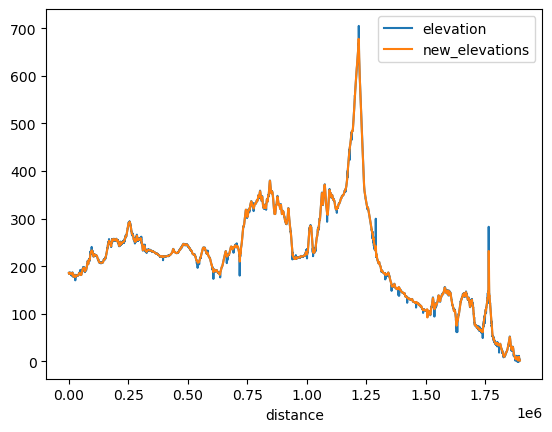

In [122]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["elevation","new_elevations"])

Let's look at the data on the end to better understand what may be going on here.

In [1]:
subseg_df = seg_df.iloc[-1100:-900]

NameError: name 'seg_df' is not defined

<Axes: xlabel='distance'>

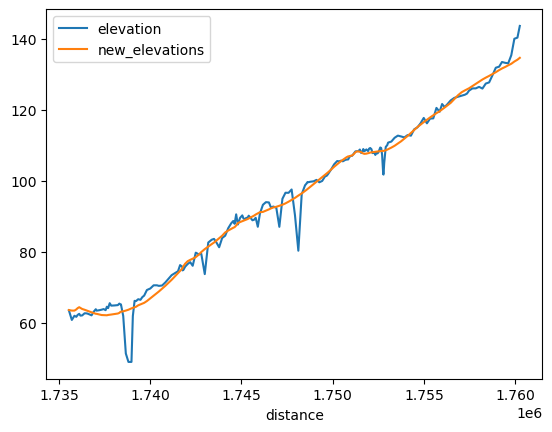

In [224]:
subseg_df.plot(x="distance", y=["elevation","new_elevations"])

<Axes: xlabel='distance'>

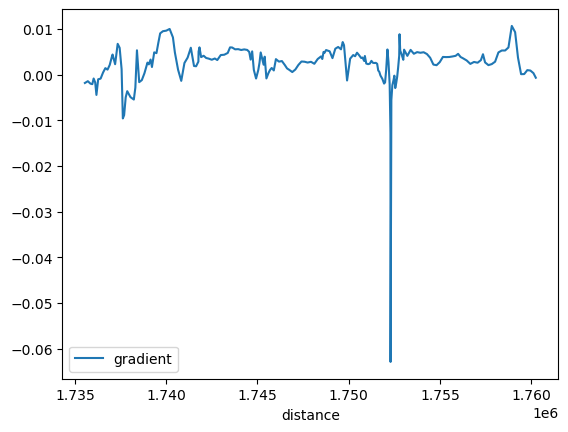

In [225]:
subseg_df.plot(x="distance", y="gradient")

Need to replace the elevations from -868 to -853 with about 142.

In [197]:
dele = np.diff(new_elevations)
len(dele)

12539

In [198]:
delx = np.diff(x)
len(delx)

12539

In [199]:
temp=delx-np.array(seg_df['length'])
temp.sum()

-4.748356374761897e-09

In [200]:
grads = np.divide(dele, delx)

In [201]:
grads.max()

0.024671846146287698

In [202]:
seg_df.gradient=grads

<Axes: xlabel='distance'>

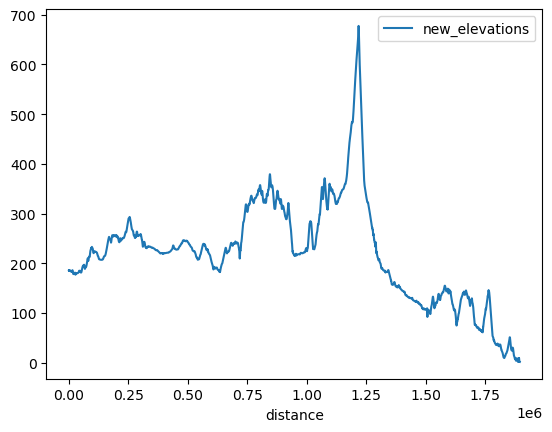

In [203]:
seg_df.plot(x="distance", y="new_elevations")

<Axes: xlabel='distance'>

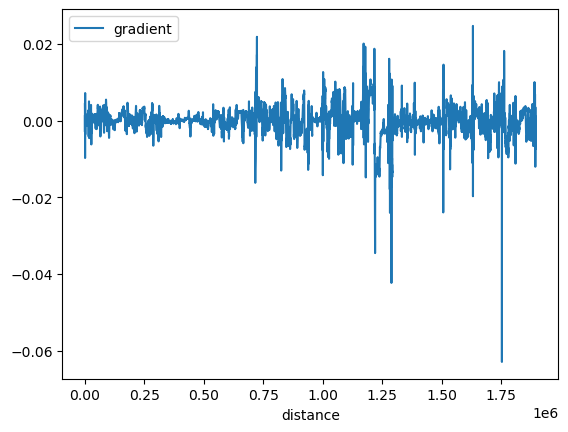

In [220]:
seg_df.plot(x="distance", y="gradient")

<Axes: xlabel='distance'>

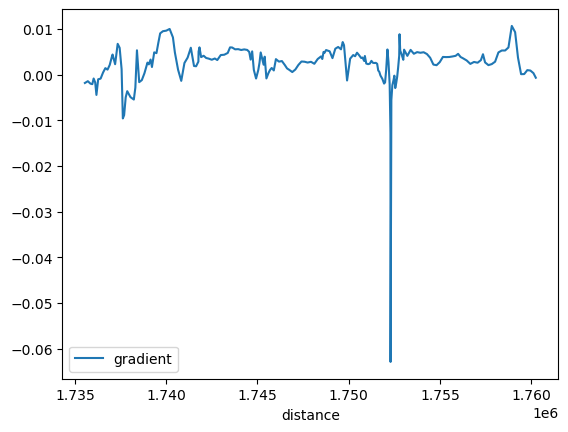

In [226]:
subseg_df.plot(x="distance", y="gradient")

In [168]:
type(seg_df)


pandas.core.frame.DataFrame

In [186]:
seg_df.iloc[-867,seg_df.columns.get_loc('elevation')]=145

In [174]:
seg_df.iloc[-856]['elevation']

151.1352081298828

In [189]:
seg_df.iloc[-860]['elevation']

145.0

ok, lets try to filter the data again.

In [190]:
y=np.insert(np.array(seg_df['elevation']),0, start_elevation, axis=0)

In [217]:
new_elevations = savgol_nonuniform(x,y, 53, 3, 0)
seg_df['new_elevations']=new_elevations[1:]

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

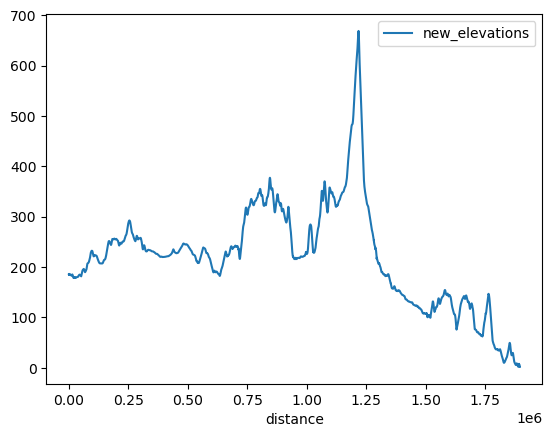

In [218]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["new_elevations"])

<Axes: xlabel='distance'>

<Figure size 1600x800 with 0 Axes>

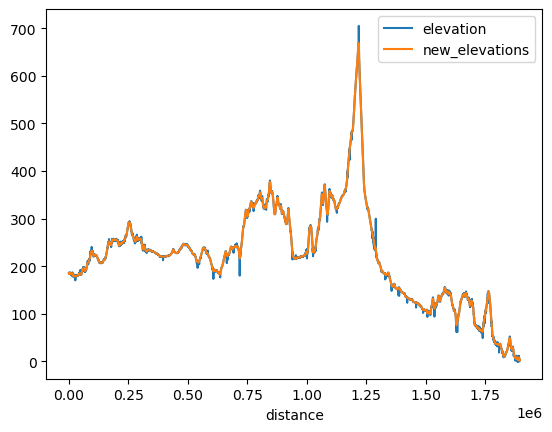

In [219]:
plt.figure(figsize=(16, 8))
seg_df.plot(x="distance", y=["elevation","new_elevations"])

<Axes: xlabel='distance'>

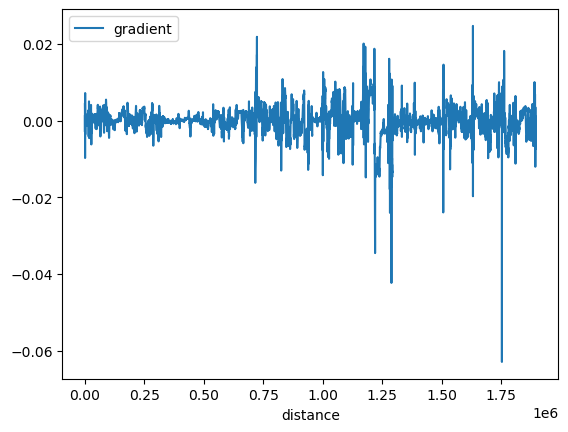

In [227]:
seg_df.plot(x="distance", y="gradient")

Let's just go through and cap the gadients to be between -0.02 and 0.02.

In [228]:
seg_df.loc[seg_df.gradient<-0.02, 'gradient']=-0.02

In [229]:
seg_df.loc[seg_df.gradient>0.02, 'gradient']=0.02

<Axes: xlabel='distance'>

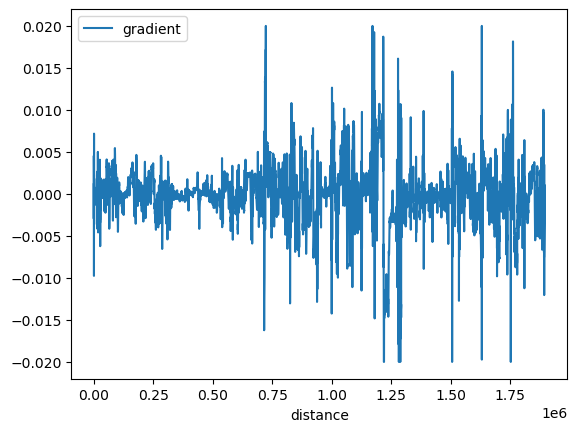

In [230]:
seg_df.plot(x="distance", y="gradient")

lets call this good for now

In [231]:
data={
    'route':5, 
    'elevations': new_elevations,
    'gradients': list(seg_df['gradient'])
}

lets try to update the elevations.

In [257]:
res = requests.post(URL9, data=data, auth=TokenAuth(token))

In [258]:
res.json()

{'detail': 'Method "POST" not allowed.'}

In [256]:
URL9

'http://score-web-1:8000/api/route/elevations/update/'

In [259]:
URL11 = URL + "/api/something/stupid/"

In [267]:
res = requests.post(URL11, data=data, auth=TokenAuth(token))

In [268]:
res.status_code

200

In [269]:
response = requests.get(URL8+'5', auth=TokenAuth(token))
print(response.status_code)
segments=response.json()['results']['segments']
start_elevation = response.json()['results']['start_elevation']
seg_df2 = pd.DataFrame(segments)

200


<Axes: xlabel='distance'>

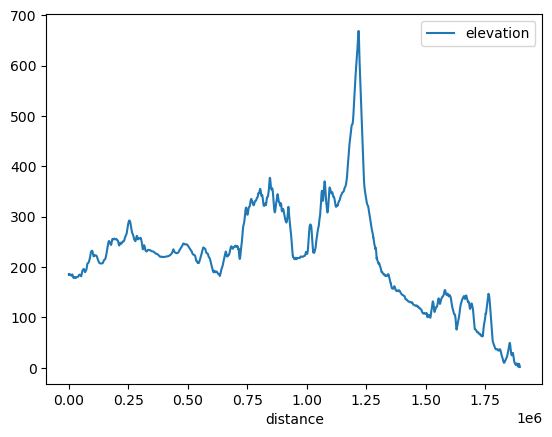

In [270]:
seg_df2.plot(x="distance", y="elevation")

<Axes: xlabel='distance'>

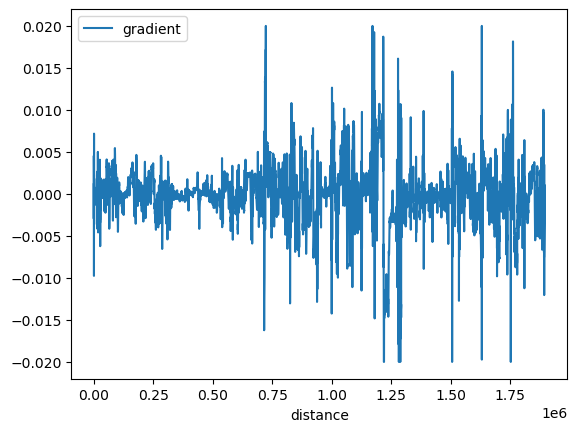

In [271]:
seg_df2.plot(x="distance", y="gradient")